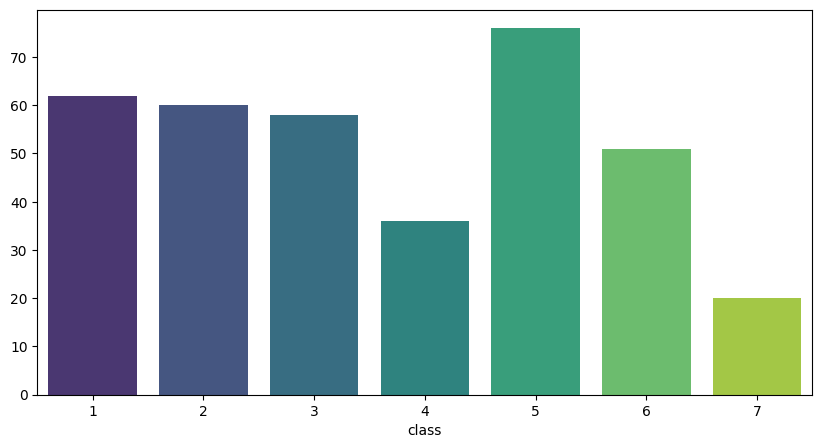

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from peakutils import baseline
import sklearn
from sklearn.model_selection import train_test_split
import seaborn as sns
import numpy as np

df = pd.read_csv('data.csv')
df = df[df['class'] != 8]
train_data, test_data = train_test_split(df, test_size=0.2, shuffle = True, random_state=42)

plt.figure(figsize=(10, 5))
sns.barplot(x=df['class'].value_counts().index, y=df['class'].value_counts().values, palette="viridis")
plt.show()

In [32]:
# pd.set_option('future.no_silent_downcasting', True)
map = {
    'class': {1:0, 2:1, 3:2, 4:3,
              5:4, 6:5, 7:6},
    'transparency': {'o': 1, 't': 2, 's': 3},
    'color': {'white': 1, 'none': 2, 'blue': 3,
              'black': 4, 'green':5, 'red': 6,
              'orange': 7, 'gray': 8, 'yellow': 9,
              'purple': 10},
    'device_id': {'B0236F1F2D02C632': 1, 'D02B30ACFD92433E': 2,
                  'B02EFC17B97B46B2': 3, '802215F15396F9FE': 4},
}
train_data = train_data.replace(map)
test_data = test_data.replace(map)

## Balancing the minority classes (Oversampling)

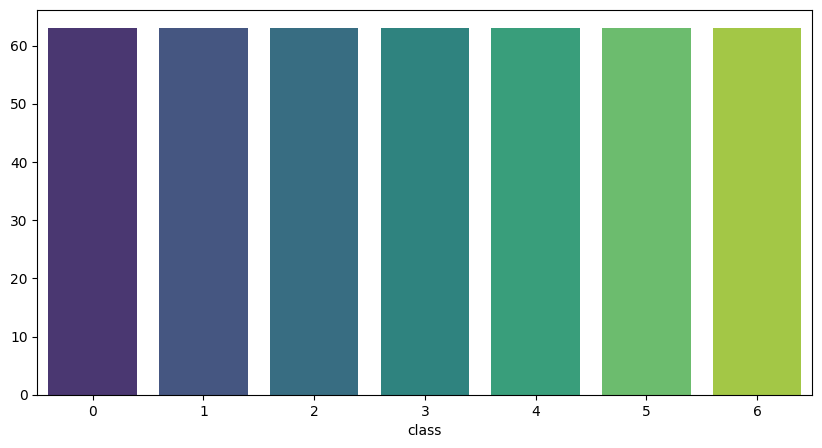

In [33]:
from imblearn.over_sampling import BorderlineSMOTE

oversampler = BorderlineSMOTE(random_state=42)
x_train, y_train = oversampler.fit_resample(train_data.iloc[:, 1:], train_data['class'])
train_data = pd.concat([y_train, x_train], axis=1)
train_data = pd.DataFrame(train_data, columns=train_data.columns)

plt.figure(figsize=(10, 5))
sns.barplot(x=train_data['class'].value_counts().index, y=train_data['class'].value_counts().values, palette="viridis")
plt.show()

In [34]:
def plot_signal(train_data, df_class=None, labels=None):
    for i, row in train_data.iterrows():
        if labels == 'yes':
            plt.plot(range(len(row)), row.values,label=f"Plasic Type: {df_class[i]}")
            plt.legend(fontsize=8)
        else:
            plt.plot(range(len(row)), row.values)
    plt.xlabel('Wavelength')
    plt.ylabel('Intensity')
    plt.show()

## Data after Oversampling

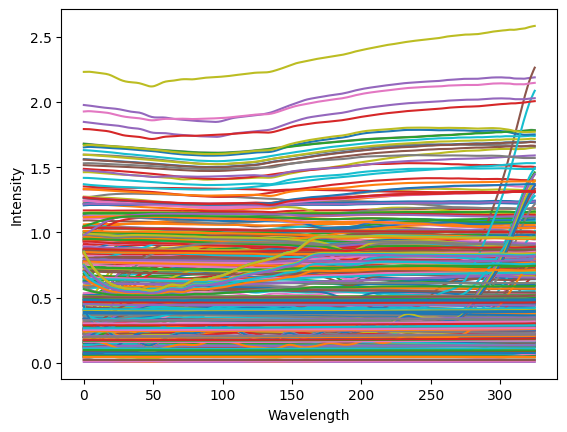

In [35]:
plot_signal(train_data.iloc[:, 5:331])

## Baseline Correction

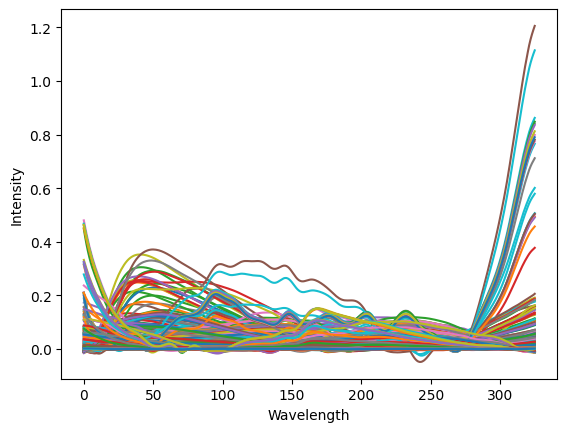

In [36]:
train_data.iloc[:, 5:331] = pd.DataFrame(np.array([row - baseline(row, deg=2) for i, row in train_data.iloc[:, 5:331].iterrows()]))
test_data.iloc[:, 5:331] = pd.DataFrame(np.array([row - baseline(row, deg=2) for i, row in test_data.iloc[:, 5:331].iterrows()]))
plot_signal(train_data.iloc [:, 5:331])

## Normalizing data

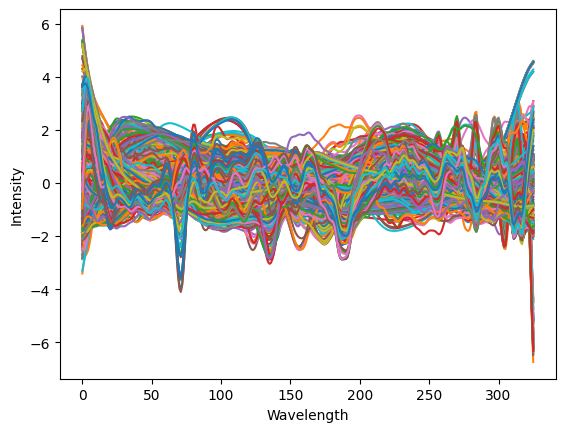

In [37]:
"https://stackoverflow.com/questions/49960288/how-to-standardize-rows-in-pandas"

train_data.iloc[:, 5:331] = train_data.iloc[:, 5:331].sub(train_data.iloc[:, 5:331].mean(1), axis=0).div(train_data.iloc[:, 5:331].std(1), axis=0)
test_data.iloc[:, 5:331] = test_data.iloc[:, 5:331].sub(test_data.iloc[:, 5:331].mean(1), axis=0).div(test_data.iloc[:, 5:331].std(1), axis=0)
plot_signal(train_data.iloc[:, 5:331])

## Savitzky Golay Filter

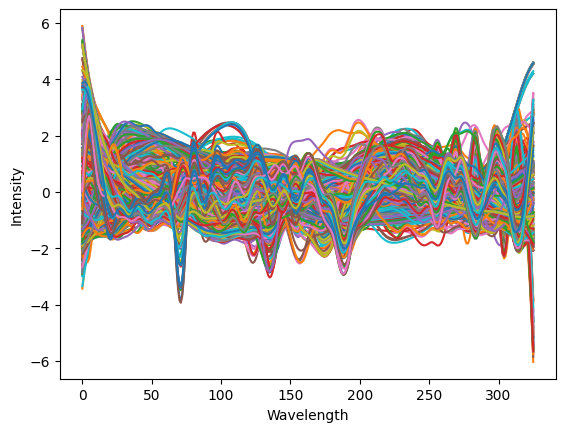

In [38]:
train_data.iloc[:, 5:331] = pd.DataFrame(savgol_filter(train_data.iloc[:, 5:331] , window_length=11, polyorder=2))
test_data.iloc[:, 5:331] = pd.DataFrame(savgol_filter(test_data.iloc[:, 5:331] , window_length=11, polyorder=2))
plot_signal(train_data.iloc[:, 5:331])

train = pd.concat([train_data[['class', 'color', 'transparency']], train_data.iloc[:, 5:331] ], axis=1)
train.to_csv('high_level/train.csv', index=False)

test = pd.concat([test_data[['class', 'color', 'transparency']], test_data.iloc[:, 5:331] ], axis=1)
test.to_csv('high_level/test.csv', index=False)

## Feature Selection

In [39]:
from sklearn.decomposition import PCA

pca = PCA(n_components=5)
train_comp = pd.DataFrame(pca.fit_transform(train_data.iloc[:, 20:310]))
test_comp = pd.DataFrame(pca.transform(test_data.iloc[:, 20:310]))
test_data = test_data.reset_index()
test_data = test_data.drop(columns=['index'])

train = pd.concat([train_data[['class', 'color', 'transparency']], train_comp], axis=1)
train.to_csv('preprocessed/train.csv', index=False)

test = pd.concat([test_data[['class', 'color', 'transparency']], test_comp], axis=1)
test.to_csv('preprocessed/test.csv', index=False)

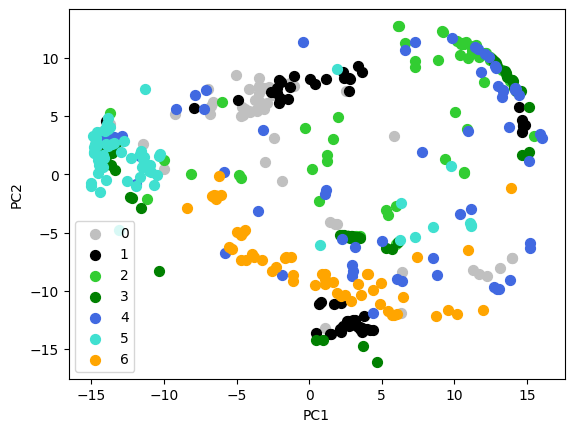

In [40]:
import plotly.express as px

targets = [0,1,2,3,4,5,6]
colors = ['silver', 'black', 'limegreen', 'green', 'royalblue', 'turquoise', 'orange']

for target, color in zip(targets, colors):
    indicesToKeep = train_data['class'] == target
    plt.scatter(train_comp.loc[indicesToKeep, 0]
               ,train_comp.loc[indicesToKeep, 1], c = color, s = 50)

plt.xlabel('PC1')   
plt.ylabel('PC2')  
plt.legend(targets)

Text(0, 0.5, 'cumulative explained variance')

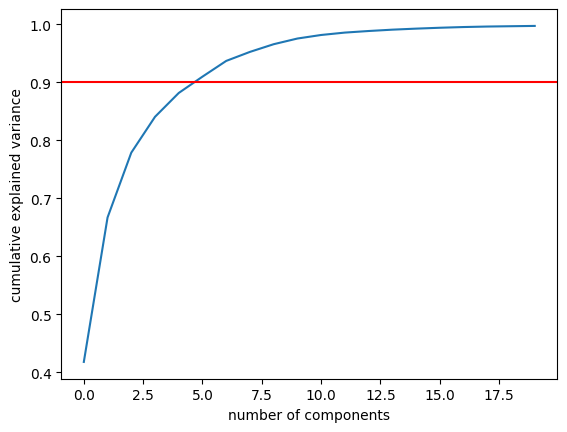

In [41]:
pca = PCA(n_components=20)
train_comp = pd.DataFrame(pca.fit_transform(train_data.iloc[:, 20:310]))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.axhline(y=0.90, color='r')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')